<a href="https://colab.research.google.com/github/assafrbi/mini-project-Digital-Humanities/blob/main/dh_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
!pip install cinemagoer
!pip install pyLDAvis
!pip install swifter

import re
from pydoc import synopsis
import requests
from bs4 import BeautifulSoup
from dateutil.parser import parse
import concurrent.futures
import pandas as pd
# import wikipedia
import numpy as np
import json
import glob
from imdb import Cinemagoer
import tqdm
import time
import nltk
# nltk.download('stopwords')
nltk.download('all')
nltk.download('punkt')
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim_models
import collections
from operator import itemgetter
from scipy import stats
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# %matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import swifter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!

### Load Data from IMDb

In [5]:
movie_title_arr = []
movie_year_arr = []
movie_genre_arr = []
image_id_arr = []
movie_synopsis_arr = []
need_wiki_id = []
need_wiki_name = []
need_wiki_year = []

In [6]:
ia = Cinemagoer()

def getSynopsisFromImdb(id):
  movie = ia.get_movie(id)
  # print("for id {}\n".format(id))
  # print("\n summary is :\n {}\n".format(movie.get('plot')[0]))
  return movie.get('plot')[0]

2022-07-15 10:52:12,853 INFO [imdbpy.parser.http.piculet] /usr/local/lib/python3.7/dist-packages/imdb/parser/http/piculet.py:262: using lxml
2022-07-15 10:52:12,853 : INFO : using lxml


In [7]:
def getMovieTitle(header):
  try:
    return header[0].find("a").getText()
  except:
    return 'NA'

def getReleaseYear(header):
  try:
    return header[0].find("span",  {"class": "lister-item-year text-muted unbold"}).getText().strip()[-5:-1]
  except:
    return 'NA'

def getGenre(muted_text):
  try:
    return muted_text.find("span",  {"class":  "genre"}).getText().strip()
  except:
    return 'NA'
        
def getsynopsys(movie, id, name, year):
  try:
    movie_synopsis = getSynopsisFromImdb(id)
    return movie_synopsis
  except:
    # no imdb data -> need wiki
    need_wiki_id.append(id)
    need_wiki_name.append(name)
    need_wiki_year.append(year)
    return 'NA'

def getImageId(image):
  try:
    return image.get('data-tconst')[2:]
  except:
    return 'NA'

In [8]:
def main(imdb_url):
  response = requests.get(imdb_url)
  soup = BeautifulSoup(response.text, 'html.parser')

  # Movie Name
  movies_list  = soup.find_all("div", {"class": "lister-item mode-advanced"})
    
  for movie in movies_list:
    header = movie.find_all("h3", {"class":  "lister-item-header"})
    muted_text = movie.find_all("p", {"class":  "text-muted"})[0]
    imageDiv =  movie.find("div", {"class": "lister-item-image float-left"})
    image = imageDiv.find("img", "loadlate")
        
    # Movie Title
    movie_title = getMovieTitle(header)
    movie_title_arr.append(movie_title)

    # Movie id
    id = getImageId(image)
    image_id_arr.append(id)
        
    # Movie release year
    year = getReleaseYear(header)
    movie_year_arr.append(year)

    # Movie Synopsys
    synopsis = getsynopsys(movie, id, movie_title, year)
    movie_synopsis_arr.append(synopsis)
        
    # Genre
    genre = getGenre(muted_text)
    movie_genre_arr.append(genre)
        

In [9]:
# An array to store all the URL that are being queried
imageArr = []

# Maximum number of pages one wants to iterate over
MAX_PAGE =51

# Loop to generate all the URLS.
for i in range(1, 1500, 50):
  imdb_url = f'https://www.imdb.com/search/title/?title_type=feature&countries=il&start={i}&ref_=adv_nxt'
  imageArr.append(imdb_url)

In [10]:
# Maximum number of threads that will be spawned
MAX_THREADS = 6

def download_stories(story_urls):
  threads = min(MAX_THREADS, len(story_urls))
  with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
    time.sleep(0.3)
    executor.map(main, story_urls)

In [ ]:
# Call the download function with the array of URLS called imageArr
download_stories(imageArr)

# Attach all the data to the pandas dataframe. You can optionally write it to a CSV file as well
movieDf = pd.DataFrame({
    "Title": movie_title_arr,
    "Year": movie_year_arr,
    "Genre": movie_genre_arr,
    "Synopsis": movie_synopsis_arr,
    "IMDb id": image_id_arr,
})

needWiki = pd.DataFrame({
    "Title": need_wiki_name,
    "Year": need_wiki_year,
    "IMDb id": need_wiki_id,
})

movieDf.to_csv('israel_originated_movies_imdb.csv')
needWiki.to_csv('movies_need_wiki.csv')

In [12]:
movieDf

,Title,Year,Genre,Synopsis,IMDb id
0,The Lost Daughter,2021,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...,9100054
1,Synonymes,2019,Drama,A woman's beach vacation takes a dark turn whe...,7016254
2,Rumpelstiltskin,1987,"Fantasy, Family, Musical",A musical version of the classic story about a...,0093891
3,A Story of David,1960,Drama,King Saul of Israel is jealous of the fame and...,0054342
4,Bloomfield,1970,Drama,"Secrets, lies, surprises and more are explored...",0068694
...,...,...,...,...,...
1466,Z'man Emet,1991,Drama,NA,0102763
1467,Windows,2014,Drama,The movie Windows is constructed from a series...,3742588
1468,Street 60,1976,"Drama, Romance",NA,5524664
1469,BaKavod Sheli,2004,Drama,NA,8317822


In [13]:
needWiki

,Title,Year,IMDb id
0,Summertime Blues: Lemon Popsicle VIII,1988,0096190
1,Lemon Popsicle 9: The Party Goes On,2001,0289730
2,Me'ever Layam,1991,0104834
3,La salamandra del deserto,1970,0067700
4,Tubianski,2014,3995806
...,...,...,...
334,Yanush Korchak,2004,0469861
335,LeShem Shenuy,2018,13136008
336,Z'man Emet,1991,0102763
337,Street 60,1976,5524664


In [17]:
complete_data = pd.read_csv('israel_originated_movies_imdb.csv', usecols=["Synopsis","Genre"]).dropna()
complete_data.to_csv('ready_for_topic_modeling.csv', index=False)

complete_data

,Genre,Synopsis
0,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...
1,Drama,A woman's beach vacation takes a dark turn whe...
2,"Fantasy, Family, Musical",A musical version of the classic story about a...
3,Drama,King Saul of Israel is jealous of the fame and...
4,Drama,"Secrets, lies, surprises and more are explored..."
...,...,...
1462,"Drama, Thriller","On the day he is released from prison, Yisarae..."
1463,Thriller,"Jake and Rachel are young, beautiful and marri..."
1464,"Drama, Romance","""All of those romantic movies are always in fo..."
1467,Drama,The movie Windows is constructed from a series...


### Load Synopses from Wikipedia - Need some tuning !!!!!!

In [ ]:
# wikiMovies = pd.read_csv('movies_need_wiki.csv')

In [ ]:
# movie_plot_arr = []
# movie_summary_arr = []
# wikipedia_title_arr = []

# def find_title_on_wikipedia(title, year):
#     search_results = wikipedia.search(title, results=20)
#     search_results_exact = [s for s in search_results if title in s] # results that have the exact title as part of them
    
#     if len(search_results_exact) != 0: # if the title is part of at least one result

#         # if film exists in title but not together with series or score (an example was Resident Evil 2002)
#         search_results_film = [s for s in search_results_exact if 'film' in s and 'score' not in s and 'series' not in s]

#         # Go on by additionaly searching for the year in the title
#         if len(search_results_film) == 0: # if there is no results with 'film' in the title
#             search_results_year = [s for s in search_results_exact if str(year) in s]
#             if len(search_results_year) == 0: # if there is no results with year in the title
#                 search_results_final = search_results_exact
#             else:
#                 search_results_final = search_results_year
#         else:
#             search_results_year = [s for s in search_results_film if str(year) in s]
#             if len(search_results_year) == 0:
#                 search_results_final = search_results_film
#             else:
#                 search_results_final = search_results_year  

#         # for the possible remains of the search results take the exact match or the first result
#         for s in search_results_final:
#             if s == title:
#                 title = s
#             else:
#                 title = search_results_final[0]
    
#     else: # take the first result
#         title = search_results[0]

#     return title

# def add_wikipedia():
#   section_names = ['Plot','Synopsis','Plot synopsis','Plot summary', 'Story','Plotline','The Beginning','Summary', 'Content','Premise']
#   for i in range (len(image_id_arr)):
#     imdb_title = movie_title_arr[i]
#     year = movie_year_arr[i]
#     title, page, plot, summary = np.nan, np.nan, np.nan, np.nan

#     try:
#       title = find_title_on_wikipedia(imdb_title, year)
#       search_results = wikipedia.search(title, results=20)
#       page = wikipedia.WikipediaPage(title = title)
#     except:
#         print(f'Title "{imdb_title}" does not exist on Wikipedia.')

#     for section in section_names:
#         try:
#             plot = page.section(section)
#         except:
#             print(f'Plot for -{imdb_title}- was not found.')

#     # for some movies with general title - modify the search by adding (year film) next to title
#     if plot is None:
#         imdb_title = f'{imdb_title} ({year} film)'
#         try:          
#             title = find_title_on_wikipedia(imdb_title, year)
#             search_results = wikipedia.search(title, results=20)
#             page = wikipedia.WikipediaPage(title = title)
#         except:
#             print(f'Title "{imdb_title}" does not exist on Wikipedia.')

#         for section in section_names:
#             try:
#                 plot = page.section(section)
#             except:
#               print(f'Plot for -{imdb_title}- was not found.')
        
#     try:
#         summary = page.summary
#     except:
#         print(f'Summary for -{imdb_title}- was not found.')        
    
#     wikipedia_title_arr.append(title)
#     movie_plot_arr.append(plot)
#     movie_summary_arr.append(summary)

In [ ]:
# data = pd.read_csv('israel_originated_movies_imdb.csv')
# add_wikipedia()

### Text Preprocessing


In [45]:
def remove_new_line_characters(text):
  return re.sub('\s+', ' ', text)

def remove_quotes(text):
  text = re.sub("\'", "", text)
  text = re.sub('\"', '', text)
  return text

def lowercase(text):
  return text.lower()    

def remove_single_char_words(text):
  return re.sub(r"\b[a-zA-Z]\b", "", text)

def remove_verbs(text):
  final_text = ''
  allowedWordTypes = ["J","R","N"]
  tokens = nltk.word_tokenize(text)
  # print(tokens)
  tagged = nltk.pos_tag(tokens)
  for w in tagged:
    if w[1][0] in allowedWordTypes:
      final_text += f' {w[0]}'
    return final_text

def text_preprocess(text):
  text = remove_new_line_characters(text)
  text = remove_quotes(text)
  text = lowercase(text)
  text = remove_single_char_words(text)
  text = remove_verbs(text)
  return text

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def make_bigrams(texts, bigram_mod):
  return [bigram_mod[doc] for doc in texts]
  
def lemmatization_x(sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  doc = nlp(" ".join(sent)) 
  return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

def join_list(the_list):
  str1 = " " 
  return str1.join(the_list)

In [46]:
ready_data = pd.read_csv('ready_for_topic_modeling.csv', usecols=["Synopsis", "Genre"])

ready_data.loc[ready_data['Synopsis']!='']
source = 'Synopsis'
data = ready_data.copy()

print(f'---Doing pre-processing for {source}..')
print('Initial pre-processing..')

data[source] = data[source].apply(lambda x: text_preprocess(x))

data = data[source].to_list()
data_words = list(sent_to_words(data))

# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100, progress_per=200) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Remove Stop Words
print('Removing stopwords..')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Creating bigrams..')
ready_data[f'{source}_words_bigrams'] = make_bigrams(data_words_nostops, bigram_mod)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print('Lemmatizing words..')
ready_data[f'{source}_lemmatized'] = ready_data[f'{source}_words_bigrams'].swifter.apply(lambda x: lemmatization_x(x))
ready_data = ready_data.drop(columns=[f'{source}_words_bigrams'])
ready_data[f'{source}_preprocessed'] = ready_data[f'{source}_lemmatized'].apply(lambda x: join_list(x))

del bigram, bigram_mod, data_words, data, nlp

ready_data

---Doing pre-processing for Synopsis..
Initial pre-processing..


2022-07-15 11:46:34,993 : INFO : collecting all words and their counts
2022-07-15 11:46:35,047 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2022-07-15 11:46:35,052 : INFO : PROGRESS: at sentence #200, processed 115 words and 109 word types
2022-07-15 11:46:35,055 : INFO : PROGRESS: at sentence #400, processed 215 words and 193 word types
2022-07-15 11:46:35,058 : INFO : PROGRESS: at sentence #600, processed 323 words and 268 word types
2022-07-15 11:46:35,061 : INFO : PROGRESS: at sentence #800, processed 432 words and 351 word types
2022-07-15 11:46:35,064 : INFO : PROGRESS: at sentence #1000, processed 558 words and 435 word types
2022-07-15 11:46:35,067 : INFO : collected 477 word types from a corpus of 626 words (unigram + bigrams) and 1118 sentences
2022-07-15 11:46:35,069 : INFO : using 477 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
2022-07-15 11:46:35,072 : INFO : source_vocab length 477
2022-07-15 11:46:35,0

Removing stopwords..
Creating bigrams..
Lemmatizing words..


Pandas Apply:   0%|          | 0/1118 [00:00<?, ?it/s]

,Genre,Synopsis,Synopsis_lemmatized,Synopsis_preprocessed
0,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...,[young],young
1,Drama,A woman's beach vacation takes a dark turn whe...,[woman],woman
2,"Fantasy, Family, Musical",A musical version of the classic story about a...,[musical],musical
3,Drama,King Saul of Israel is jealous of the fame and...,[],
4,Drama,"Secrets, lies, surprises and more are explored...",[secret],secret
...,...,...,...,...
1113,"Drama, Thriller","On the day he is released from prison, Yisarae...",[],
1114,Thriller,"Jake and Rachel are young, beautiful and marri...",[jake],jake
1115,"Drama, Romance","""All of those romantic movies are always in fo...",[],
1116,Drama,The movie Windows is constructed from a series...,[],


#### Most common words


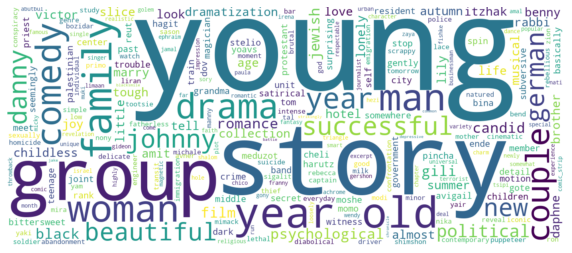

In [47]:
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    max_words=2000,
    contour_width=3,
    contour_color='steelblue',
    width=1400,
    height=600)
# Join the different processed titles together.
long_string = ','.join(ready_data[f'{source}_preprocessed'].to_list())
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.savefig(f'wordcloud.png', dpi = 300)
plt.show()

### Topic Modeling - Latent Dirichlet Allocation

In [48]:
def allocate_topics(i):
  return lda_model[corpus[i]][0]

def get_max_probability_topic(x, num_topics):
  return  max(x, key=itemgetter(1))[0]

def build_LDA_model(ready_data, source, num_topics):
  # Create the Dictionary and Corpus needed for Topic Modeling
  # Create Dictionary
  #id2word = corpora.Dictionary(data_lemmatized)
  id2word = corpora.Dictionary(ready_data[f'{source}_lemmatized'].tolist())
  # Create Corpus
  texts = ready_data[f'{source}_lemmatized'].tolist()
  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]
  del texts
  # Build LDA model
  lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=7,
                                               eval_every=10,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=8)   
  return lda_model, corpus, id2word

def compute_metrics_per_topics(ready_data, source):
  # Calculate the frequency of words for this topic and for all corpora

  # Computed once for all corpus
  corpora_word_counts = [e.split(' ') for e in ready_data[f'{source}_preprocessed'].tolist()]
  corpora_word_counts = [item for sublist in corpora_word_counts for item in sublist]
  corpora_word_counts = collections.Counter(corpora_word_counts)
  corpora_word_counts_df = pd.DataFrame.from_dict(corpora_word_counts, orient='index')

  metrics = pd.DataFrame()
  for topic_n in ready_data[f'{source}_topic'].unique():
      topic_word_counts = [e.split(' ') for e in ready_data.loc[ready_data[f'{source}_topic']==topic_n][f'{source}_preprocessed'].tolist()]
      topic_word_counts = [item for sublist in topic_word_counts for item in sublist]
      topic_word_counts=collections.Counter(topic_word_counts)
      topic_word_counts_df = pd.DataFrame.from_dict(topic_word_counts, orient='index')

      word_counts_df = corpora_word_counts_df.merge(topic_word_counts_df, left_index=True, right_index=True, how='left').\
      rename({'0_x': 'corpora','0_y': f'{source}_topic'}, axis=1)
      word_counts_df = word_counts_df.fillna(0)

      metrics = metrics.append({'Topic': topic_n,
                                  'Probability': len(topic_word_counts)/len(corpora_word_counts_df),
                                  'Entropy': stats.entropy(pk=word_counts_df[f'{source}_topic'].values),
                                  'KL': stats.entropy(pk=word_counts_df[f'{source}_topic'].values, qk=word_counts_df['corpora'].values)
                   }, ignore_index=True) 

  return metrics.sort_values(by='Probability')    

def create_topic_specific_wordcloud(ready_data, source, topic):
  # Create a WordCloud object for specific topic
  temp = ready_data.loc[ready_data[f'{source}_topic']==0][f'{source}_preprocessed'].to_list()
  wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue',
                         width=1800, height=900)
  # Join the different processed titles together.
  long_string = ','.join(temp)
  # Generate a word cloud
  wordcloud.generate(long_string)
  # Visualize the word cloud
  return wordcloud.to_image()

In [52]:
# ready_data = pd.read_csv('israel_originated_movies_imdb.csv', usecols=["Synopsis","Genre"])
num_topics = 6
# stopwords = stopwords.words("english")
lda_model, corpus, id2word = build_LDA_model(ready_data, source=source, num_topics=num_topics)

lda_model.print_topics()
print('stage 5 done')

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

ready_data['i'] = [i for i in range(len(ready_data))]
ready_data[f'{source}_topic'] = ready_data['i'].swifter.apply(lambda x: allocate_topics(x))
ready_data[f'{source}_topic'] = ready_data[f'{source}_topic'].apply(lambda x: get_max_probability_topic(x, num_topics))

KeyError: ignored